# Loading the libraries

In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from shutil import copyfile
from shutil import rmtree

In [3]:
import random
from PIL import Image

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Creating training and validation directories

In [5]:
categories=os.listdir(path='../input/state-farm-distracted-driver-detection/imgs/train')  # Storing the possible output classes

In [6]:
categories=sorted(categories) # Sorting the classes

In [7]:
categories

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [8]:
base_dir="../input/state-farm-distracted-driver-detection/imgs/train"

In [9]:
# Creating the master directory, train category, test category

try:
    os.mkdir('master_data')
except:
    rmtree('master_data')
    os.mkdir('master_data')
    
    
os.mkdir('master_data/train')
os.mkdir('master_data/validation')

In [10]:
# Creating the class directories

for category in categories:
    os.mkdir(os.path.join('master_data/train',category))
    os.mkdir(os.path.join('master_data/validation', category))

In [11]:
split_size=0.8  # train test split

for category in categories:
    category_folder=os.path.join(base_dir,category)
    images=os.listdir(category_folder)  # Getting all the images in this class
    
    
    # Shuffling the images
    
    random.shuffle(images)
    
    train_size=int(split_size*len(images))
    
    train_images=images[:train_size]  # train images array
    validation_images=images[train_size:] # validation images array
    
    
    # populating the training directories
    for image in train_images:
        source=os.path.join(base_dir,category,image)
        destination=os.path.join('master_data/train',category,image)
        #print(source,destination)
        copyfile(source,destination)
        
    # populating the validation directories
    for image in validation_images:
        source=os.path.join(base_dir,category,image)
        destination=os.path.join('master_data/validation',category,image)
        copyfile(source,destination)
    

# Data Generators

In [12]:
# Creating the data generator objects
train_data_gen=ImageDataGenerator(rescale=1.0/255)

In [13]:
train_data_generator=train_data_gen.flow_from_directory("master_data/train", 
                                                         target_size=(224,224), batch_size=256, class_mode='categorical')

Found 17934 images belonging to 10 classes.


In [14]:
validation_data_gen=ImageDataGenerator(rescale=1.0/255)

In [15]:
validation_data_generator=validation_data_gen.flow_from_directory("master_data/validation", 
                                                         target_size=(224,224), batch_size=256, class_mode='categorical')

Found 4490 images belonging to 10 classes.


# Building the model

In [16]:
# I am using VGG 16 model to do transfer learning so that accuracy can be increased and training time can be decreased

In [17]:
Input_Shape=(224,224)

In [18]:
Input_Shape+(3,)

(224, 224, 3)

#### Using the vgg16 model for transfer learning

In [19]:
vgg=VGG16(input_shape=Input_Shape+(3,),include_top=False, pooling='max')        # Creating the vgg model

2021-11-05 12:44:32.150884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 12:44:32.250115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 12:44:32.250797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 12:44:32.251970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [20]:
# Making the inner layers of model as non trainable
for layer in vgg.layers:
    layer.trainable=False

### Adding the last layers

In [21]:
flattened=Flatten()(vgg.output)

In [22]:
output_layer=Dense(10,activation='softmax')(flattened)

In [23]:
# Making the model object

model=Model(inputs=vgg.input, outputs=output_layer)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Compiling the model

In [25]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
es=EarlyStopping(min_delta=0.01, patience=2) # Creating the early stopping object


# Training the model

In [27]:
model.fit(train_data_generator,validation_data=validation_data_generator,callbacks=[es], verbose=True, epochs=25)

2021-11-05 12:44:37.803321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2021-11-05 12:44:40.958014: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


71/71 [==============================] - 164s 2s/step - loss: 2.1660 - accuracy: 0.4008 - val_loss: 1.2028 - val_accuracy: 0.7094
Epoch 2/25
71/71 [==============================] - 128s 2s/step - loss: 0.9637 - accuracy: 0.7809 - val_loss: 0.7509 - val_accuracy: 0.8430
Epoch 3/25
71/71 [==============================] - 128s 2s/step - loss: 0.6481 - accuracy: 0.8652 - val_loss: 0.5740 - val_accuracy: 0.8804
Epoch 4/25
71/71 [==============================] - 128s 2s/step - loss: 0.5005 - accuracy: 0.8973 - val_loss: 0.4728 - val_accuracy: 0.8958
Epoch 5/25
71/71 [==============================] - 129s 2s/step - loss: 0.4162 - accuracy: 0.9093 - val_loss: 0.3989 - val_accuracy: 0.9105
Epoch 6/25
71/71 [==============================] - 128s 2s/step - loss: 0.3533 - accuracy: 0.9262 - val_loss: 0.3318 - val_accuracy: 0.9276
Epoch 7/25
71/71 [==============================] - 129s 2s/step - loss: 0.3044 - accuracy: 0.9367 - val_loss: 0.3065 - val_accuracy: 0.9321
Epoch 8/25
71/71 [======

### We are getting 94.5% validation accuracy!!!

# Saving the model

In [28]:
model.save('./DistractedDriver.h5')

# Predicting for some images

###### The 10 classes to predict are:
<ul>
    <li>c0: normal driving</li>
    <li>c1: texting - right</li>
    <li>c2: talking on the phone - right</li>
    <li>c3: texting - left</li>
    <li>c4: talking on the phone - left</li>
    <li>c5: operating the radio</li>
    <li>c6: drinking</li>
    <li>c7: reaching behind</li>
    <li>c8: hair and makeup</li>
    <li>c9: talking to passenger</li>
   </ul>

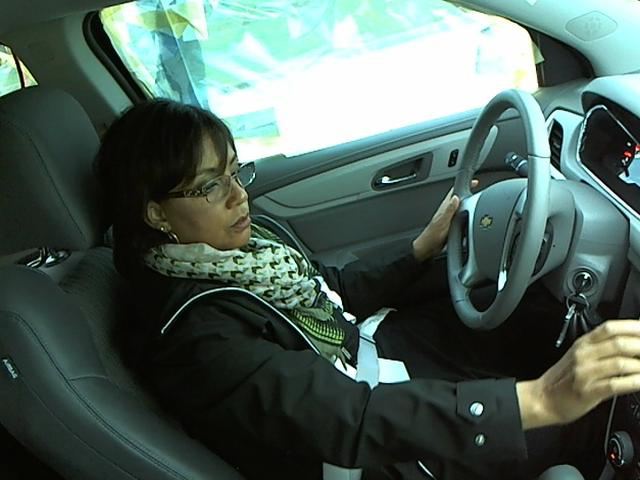

In [29]:
# Using Image module 
Image.open('../input/state-farm-distracted-driver-detection/imgs/test/img_1.jpg')

In [30]:
img=Image.open('../input/state-farm-distracted-driver-detection/imgs/test/img_1.jpg')

In [31]:
img=img.resize(Input_Shape) # Resizing the image to (224,224,3)

In [32]:
img=np.array(img)  # Converting image to numpy array

In [33]:
img=img/255 # normalization

In [34]:
img.shape

(224, 224, 3)

In [35]:
img=img[np.newaxis,...]  # Adding the new axis so that input is in right format. We can have many inputs in 1 go. Hence we 
                        # need to add another dimension to inputs with the 1st dimension being no of inputs.  Dimension of input 
                        # now is (1,224,224,3)  with 1st dimension being number of inputs

In [36]:
prediction=model.predict(img)

In [37]:
prediction

array([[7.7874586e-04, 1.5069815e-02, 7.2769105e-02, 1.2993217e-03,
        5.1475884e-03, 8.5728455e-01, 1.2428756e-02, 1.6771389e-04,
        1.1254090e-02, 2.3800267e-02]], dtype=float32)

In [38]:
categories

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [39]:
prediction_index=prediction.argmax()

In [40]:
categories[prediction_index]

'c5'